# Elevator simulation 

Code written in June and July 2020 by Camille Forns and Jonathan Perun during their internship of second year of engineering school at the ENTPE supervised by ChB (Licit, ENTPE/ Université Gustave Eiffel). The code was first improved by ChB. Then it was arranged by Thibault Charlottin and Anthony Grasser in 2021. ChB polished it a second time. Then in 2022 Flore Barré and Elisa Diot-Quéré traduced it in English and published it in Gitbub.

The following version is simplified and meant for a basic use. There is a unique simulation of a unique hotel containing one single elevator. All users are alone in their room and stay for one single night.

Use this version to test the impact of encouraging the use of the stairs instead of the elevator on the energy consumption of the elevator.

### Several informations before starting
When coding, you start by defining all of the things that will be used later on. It is worth noting that the proper simulation is located at the bottom of this page, where a cell indicates "this is where the simulation of the hotel is executed". There are two types of cells in this notebook. Cells containing text, like this one which are meant to introduce the structure and add comments. They are called "Markdown".

# Import of the useful and available modules 
To start with, we need to import the useful modules for calculation.
For this simulation, we need the *random* module to randomly generate the hours of movement. The unit *np* will be useful for some calculations, *matplotlin.pyplot* to draw graphs and *statistics* to interpret our results. We will use *pandas* to present our results with tables.

In [1]:
# This cell is a cell code as you can see by clicking above on the tab "cell" which at the "cell type" offers us markdown 
# or code. If you change the type of the cell to mardown, it is not code anymore !


# In a cell code, if you do not want to execute a line or a part of line you just have to add an 
# "#" before the related component
# By the way, it seems important to point out that a good code is a code with COMMENTS. 
# Indeed, a code without comments is not understandable
# However, be careful to avoid useless comments like this one which do not increase the readability 
# of your code...on the opposite 

import random as rd 
# 'as rd' allows to rename our unit to make it shorter 

import numpy as np # same reason (also you can notice there how "#" can be used at the end of a 
# line to indicate a comment) 

import matplotlib.pyplot as plt

import statistics 

import pandas as pd

#(1) : because "Repetition is the mother of teaching" 

### Definition of the constants

We define all of the constants that will step in our calculations and that will stand still during the entire simulation.
These constants can obviously be changed between different simulations.

For every trip, the user has a probability different from 0 of using the stairs instead of the elevator to go up or down.

In [2]:
PROBA_DOWN_ST = 0.3 
PROBA_UP_ST = 0.00

The user can lose patience when waiting for the elevator. When going beyond "LOSEP_DURATION", the probability of going up or down by the stairs is multiplied by "LOSEP_FACTOR"

In [3]:
LOSEP_DURATION = 60 #s = 1 minute
LOSEP_FACTOR = 2

It is also necessary to consider the average weight of the users because the energy cost of a trip is related to the weight carried by the elevator.

In [4]:
AVG_WT = 65 #kg

### Definition of the parameters of the movements in the hotel
#### Movements taken into account
We only pay attention to vertical movements using the elevator or the stairs. The horizontal movements taking place in the corridors are not taken into account. Also, we only consider the movements of the clients of the hotel and ignore the movements of the staff (cleaning, room service,...) 

#### Movements of the clients
The clients check-in at the end of the day and check-out before noon on the following day. In total, they can do a maximum of 8 vertical movements :

*1* When they arrive, they reach their room. 

*2* They can go out for dinner or a drink,

*3* in that case, they go up to their room afterwards 

*4* some of them go to the reception of the hotel to ask for some informations

*5* then they go back upstairs

*6* most of them go downstairs during the hours of service to the breakfast area

*7* then they go back upstairs

*8* finally, all of them leave the hotel at the end of their stay

#### Arrival (*1*) and departure (*8*) 
We define the average check-in time of the clients and its standard deviation. We do the same thing for the hour of check-out. 

In [5]:
AVG_CI_H = 68400 #s = 7 P.M
SD_CI_H = 7200 #s = 2 hours
AVG_CO_H = 118800 #s = 9 A.M on the following days
SD_CO_H = 7200 #s = 2 hours

#### Descent (*2*) and ascension (*3*) when going out at the end of the day
Going out is planned to take place between BEG_GO_OUT_H and END_GO_OUT_H.
The users that do have an BEG_GO_OUT_H generated have a 90% probability of going out to have dinner. This probability decreases until being null at END_GO_OUT_H.

In [6]:
BEG_GO_OUT_H = 70200 #s = 7 : 30 PM
END_GO_OUT_H = 82800 #s = 11 PM
PROBA_BEG_GO_OUT = 0.9
AVG_GO_OUT_DURATION = 9000 #s = 2 hours and 30 minutes
SD_GO_OUT_DURATION = 3600  #s = 1 hour
MIN_GO_OUT_DURATION = 1800 #s = 30 minutes
MAX_GO_OUT_DURATION = 11940 #s = 3 hours and 19 minutes

##### Descent at the reception (*4*) and rise (*5*)
For whatever reason, each user has a probability of 5% of descending to the reception for a constant and identical for every user duration.
We judge that if this descent actually takes place, it occurs somehow between the check-in and the check-out time of the user.

In [7]:
PROBA_DOWN = 0.05 # 
DURATION_DOWN = 360 #s = 6 minutes

#### Breakfast (*6* et *7*)
It is possible to have breakfast between BEG_BF_H et END_BF_H.

PROBA_BF corresponds to each user's probability of having breakfast. We also take into account the average and minimum duration of breakfast as well as the standard deviation of this duration.
We will also need of BRUSHING_TEETH_DURATION because a certain amount of time flows by for every user between the return to the room after having breakfast and the hour of departure.
We consider that the hour of going downstairs to the breakfast area and its meal time allows the user to stay for 15 minutes in its room before its hour of departure from the hotel (in order to brush its teeth or pack up).
 

In [8]:
BEG_BF_H = 109800 #s = 6:30 AM on the following day
END_BF_H = 120600 #s = 9:30 AM on the following day
PROBA_BF = 0.8
AVG_BF_DURATION = 1800 #s = half an hour
SD_BF_DURATION = 360  #s = 6 minutes
MIN_BF_DURATION = 360 #s = 6 minutes
MAX_BF_DURATION = 10800 #s = 3 hours, it is the opening duration of the breakfast area
BRUSHING_TEETH_DURATION = 900 #s = 15 minutes

### Definition of a few useful functions : 

sec2h allows us to easily convert a duration from seconds to hours, this function is very important, especially when returning text because time in seconds is not very indicative. We also need to take into account the fact that seconds keep passing after midnight while hours automatically reset at 0 at midnight.

h2sec does the opposite job

Finally h2secD gives the duration in seconds matching with h hours. No need to make the distinction between before and after midnight for this function.

In [9]:
def sec2h (t):
    if t <= 86400 - 1:
        return(t / 3600)
    else:
        return((t-(86400 - 1))/3600)
    
def h2sec (h):
    if 12<h<24:
        return (h*3600)
    else:
        return (h*3600 + 24*3600)
        
def h2secD (h):
        return (h*3600)
    

### Definition of the classes

#### Class of the customers

In [10]:
class Customer :

    def __init__(self, available_floor):
        self.proba_up_st = PROBA_UP_ST
        self.proba_down_st = PROBA_DOWN_ST 
        self.floor = self.affectation(available_floor)
        (self.bf_h, self.bf_duration, self.co_h) = self.proba_bf()
        self.ci_h = self.ci()
        (self.go_out_h, self.go_out_duration) = self.proba_go_out()
        self.down_h = self.proba_down()
        (self.ci_up, self.bf_down) = self.proba_evt()
        self.co_down = self.proba_evt()[1]
        self.go_out_down = self.proba_evt()[1]
        self.down_down = self.proba_evt()[1]
        self.cumul_wait_time = 0
        self.wait = 0
        self.status = "free"
        self.loc_memory = []
        self.time_memory = []


    def __str__(self):
        return("The features of the traveler are : \n\
        Breakfast at {} \n\
        Mean of descending to have breakfast: {} (1:elevator, 0:stairs) \n\
        floor: {} \n\
        The user checks in in the evening at {} \n\
        Mean of going up at the arrival {} \n\
        The user takes {} to have breakfast ".format(sec2h(self.bf_h), self.bf_down, self.floor, sec2h(self.ci_h), self.ci_up, sec2h(self.bf_duration)))


    def affectation(self, available_floor):
        floor = available_floor.index(max(available_floor))
        if floor == 0:
            print("the hotel is fully booked")
        else:
            # We get the index number of the maximum of available_floor
            # this matches with the most available floor by adding one
            # we assign to the user this floor.
            available_floor[available_floor.index(max(available_floor))]-=1
            # since we assigned to a user a floor, we need to change available_floor, 
            # the availability of the floor diminishes
            return(floor)
        
    def proba_bf(self):
        (bf_h, bf_duration, co_h)=(0,0,0)
        if rd.random() <= PROBA_BF:
        # This condition comes up in the case where the user has breakfast.
            bf_duration = int(max(MIN_BF_DURATION, rd.gauss(AVG_BF_DURATION,SD_BF_DURATION)))
            bf_duration = min(bf_duration, MAX_BF_DURATION)
            # We first define the duration, we make sure it is neither too long nor too short
            bf_h = rd.randint(BEG_BF_H, END_BF_H- bf_duration - 10*60)
            # We finally define the hour of breakfast while making sure it finishes on time.
            # We add up a "safety blanket" of 10 minutes ("10*60").
            return(bf_h, bf_duration, co_h)
        else:
            co_h = int(rd.gauss(AVG_CO_H, SD_CO_H))
            # If the user does not have breakfast, we can directly determine the hour of his departure.
            return(bf_h, bf_duration, co_h)


    def ci(self):
        return(int(rd.gauss(AVG_CI_H,SD_CI_H)))
        # We can directly calculate the hour of arrival of the user, which will be useful later on for the hour of outing.


    def proba_go_out(self):
        go_out_duration = int(max(MIN_GO_OUT_DURATION, rd.gauss(AVG_GO_OUT_DURATION, SD_GO_OUT_DURATION)))
        go_out_duration = min(MAX_GO_OUT_DURATION, go_out_duration)
        # This two first lines allows us to mark out the boundaries of the hour of outing.
        # MIN_GO_OUT_DURATION <= go_out_duration <= MAX_GO_OUT_DURATION
        go_out_h= max(self.ci_h + 10*60, rd.randint(BEG_GO_OUT_H , END_GO_OUT_H - go_out_duration - 10*60 ))
        # We generate the hour of going out by taking a random integer within the available time slot for outing.
        # It is necessary to take into account the duration of the outing so it does not start too late.
        # We leave a 10 minutes blanket between the boundaries to be safe.
        probability_go_out=((END_GO_OUT_H - go_out_h)/(END_GO_OUT_H - BEG_GO_OUT_H ))*0.9
        # We calculate the probability matching the previous hour, knowing that for BEG_GO_OUT_H  the probability is of 0.9
        # and that at END_GO_OUT_H the probability is of 0.
        if rd.random() <= probability_go_out:
        # Finally, we test if the user decides to go out or no.
            return(go_out_h, go_out_duration)
        else:
            return(0, 0)


    def proba_down(self):
    # During this step, we identify the intervals of time when it is possible to have a descent        
        l=[]
        if (self.go_out_h, self.go_out_duration) != (0, 0) and self.ci_h + 10*60 < self.go_out_h - 10*60 - DURATION_DOWN:
        # We check if there user goes out or no. If he does, the hours are equal to 0
            l.append(rd.randint(self.ci_h + 10*60, self.go_out_h - 10*60 - DURATION_DOWN))
            # If there is an outing, there can be a descent between the check-in hour and the beginning of the outing.
            # We leave a safety blanket of 10 minutes.
            if (self.bf_h, self.bf_duration) != (0, 0) and self.go_out_h + self.go_out_duration + 10*60 < self.bf_h - 10*60 - DURATION_DOWN:
            # We also test if there is a breakfast to know if there is a possibility of descent between the outing and the breakfast    #the outing actually is breakfast
                l.append(rd.randint(self.go_out_h + self.go_out_duration + 10*60, self.bf_h - 10*60 - DURATION_DOWN))
            else:
            # If there is not breakfast, there can be a descent between the hours of check-in and check-out.
                l.append(rd.randint(self.go_out_h + self.go_out_duration + 10*60, self.co_h - 10*60 - DURATION_DOWN))
        else:
        # We repeat and adapt the previous process in the case where the user does not go out
            if (self.bf_h, self.bf_duration) != (0, 0) and self.ci_h - 10*60 < self.bf_h - 10*60 - DURATION_DOWN:
                l.append(rd.randint(self.ci_h + 10*60, self.bf_h - 10*60 - DURATION_DOWN))
            else:
                l.append(rd.randint(self.ci_h + 10*60, self.co_h - 10*60 - DURATION_DOWN))
        if rd.random() <= PROBA_DOWN:
        # we use PROBA_DOWN to check if there is an outing or no.
            return(rd.choice(l))
        else:
            return(0)


    def proba_evt(self):
    # We look at in function of PROBA_DOWN_ST and PROBA_UP_ST if the person takes the stairs or no,
    # This method sends a tuple. It is up to us to name it properly if we only want the rise or the descent.
    # 0 = stairs, 1 = elevator
        if rd.random() <= self.proba_down_st:
            down = 0
        else:
            down = 1
        if rd.random() <= self.proba_up_st:
            up = 0
        else:
            up = 1
        return(up, down)


#### Class of the hotel

In [11]:
NB_FLOOR  = 12
NB_EVT = 3
NB_ROOM_PER_FLOOR = 15
NB_CUSTOMER_PER_ROOM = 1
FLOOR_HEIGHT = 3 # in meters
AVG_OCCUPANCY = 0.4
SD_OCCUPANCY = 0.1
DAY_DURATION = 24

For the class *Hotel*, the constants are directly defined within the class.

In [12]:
class Hotel :

    def __init__(self,BEG_BF_H = (24+6.5)*3600, END_BF_H = (24+9.5)*3600,
                 BEG_GO_OUT_H = 19.5*3600, END_GO_OUT_H = 23*3600):

        self.NB_FLOOR = NB_FLOOR
        self.NB_EVT = NB_EVT
        self.NB_ROOM_PER_FLOOR = NB_ROOM_PER_FLOOR
        self.NB_CUSTOMER_PER_ROOM = NB_CUSTOMER_PER_ROOM
        TOT_NB_ROOM = NB_ROOM_PER_FLOOR * NB_FLOOR
        self.TOT_NB_ROOM = TOT_NB_ROOM
        MAX_TOT_NB_CUSTOMER = TOT_NB_ROOM * NB_CUSTOMER_PER_ROOM
        self.MAX_TOT_NB_CUSTOMER = MAX_TOT_NB_CUSTOMER
        self.FLOOR_HEIGHT = FLOOR_HEIGHT

        self.AVG_OCCUPANCY = AVG_OCCUPANCY
        self.SD_OCCUPANCY= SD_OCCUPANCY
        #self.NB_TRAV = 0

        self.DAY_DURATION = DAY_DURATION
        self.BEG_BF_H = BEG_BF_H
        self.END_BF_H = END_BF_H
        self.BEG_GO_OUT_H = BEG_GO_OUT_H
        self.END_GO_OUT_H = END_GO_OUT_H

        # available_floor = [0] + NB_FLOOR * [NB_ROOM_PER_FLOOR]
        # The indent of the list starts at 0 so we can add a floor 0 corresponding to the ground floor, 
        # with 0 room on it
        # It is conveninent because it enables to have available_floor[1] = nb of rooms available on the first floor
        # self.available_floor = available_floor

    def __str__(self):
        return ("The charateristics of the hotel are : \n - {} floors \n - {} elevators \n - {} travellers \n - {} rooms per floors".format(self.NB_FLOOR, self.NB_EVT, self.NB_TRAV, self.NB_ROOM_PER_FLOOR))
        # By doing print(hotel1) you get the charateristics of the hotel.

    def nb_trav(self):
        occupancy = np.random.randn()*self.SD_OCCUPANCY+ self.AVG_OCCUPANCY # normal distribution
        # np.random.randn() randomly chooses a number between -1 and 1 by following the standard normal distribution
        # we multiply by the standard deviation and add up the average occupancy to get our standard normal distribution.
        self.NB_TRAV = int(occupancy * self.MAX_TOT_NB_CUSTOMER) # The number of travellers is an integer.
        return "There are " + str(self.NB_TRAV) + " travellers"

    def pilote1(floor_departure, floor_arrival, index_number_u, purpose, t, e, u, list_evnt_evt_ord, step, wait_list,nb_ride_st,withdrawal):
        e_available = [] # We try to establish which elevators are available, that is to say all the elevators that are 
        # not moving or carrying passengers
        if floor_departure<int(NB_FLOOR/2) and floor_arrival==0 or floor_departure==0 and floor_arrival<int(NB_FLOOR/2) :     
            # First Category of elevators
            for evt in e[0:int(NB_EVT/4)] : # We go through the list of the elevators
                if evt.mission == []: # if the elevator is not doing anything, it means it is available
                    e_available.append(evt) # We add it to the list of the available elevators                
            if e_available != [] : # We look if there is an elevator available.
                if len(e_available) == 1 : # if there is only one elevator available, we choose it.
                    ref = e_available[0]
                else : # Otherwise, we look for the closest elevator available.
                    ref = e_available[0] # We take the first elevator on the list as reference.
                    dif_ref = abs(ref.location - floor_departure) 
                    # The gap between the floor where the elevator is currently located and the floor where the user is 
                    # waiting corresponds to the absolute value of the difference between the two floors.                   
                    for evt in e_available : # We go through the list of the elevators available.
                        dif = abs(evt.location - floor_departure)
                        if dif < dif_ref : # We compare the gap calculated with the reference elevator.
                            ref = evt # If the gap is smaller, the elevator becomes the reference elevator.
                            dif_ref = dif
                if ref.location == floor_departure : # If the elevator already is at the same floor than the user
                    ref.nb_user += 1 # the user takes the elevator
                    u[index_number_u].loc_memory.append(ref.location)
                    u[index_number_u].time_memory.append(t)
                    u[index_number_u].wait = 0
                    u[index_number_u].status = "free"
                    ref.mission = [floor_arrival,"drop",0,index_number_u,purpose] 
                    # the goal of the elevator is to go to the floor of destination of the user and drop him there.
                    if floor_arrival - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST # the elevator starts up which implies an energy cost.
                else : # otherwise
                    ref.mission = [floor_departure,"pick up",floor_arrival,index_number_u,purpose] 
                    # the goal of the elevator is to pick up the user.
                    if floor_departure - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST
           
            # If there is no elevator available in this category, we reach the third category
            if e_available==[] :
                for evt in e[int(3*NB_EVT/4):] : # We go through the list of the elevators
                    if evt.mission == []: # If the elevator is not doing anything, in means it is available
                        e_available.append(evt) # We add it to the list of the available elevators 
            if e_available != [] : # We look if there is an elevator available.
                if len(e_available) == 1 : # if there is only one elevator available, we choose it.
                    ref = e_available[0]
                else : # Otherwise, we look for the closest elevator available.
                    ref = e_available[0] # We take the first elevator on the list as reference.
                    dif_ref = abs(ref.location - floor_departure) 
                    # The gap between the floor where the elevator is curently located and the floor where the user is
                    # waiting corresponds to the absolute value of the difference of the two floors.
                    for evt in e_available : # We go through the list of available elevators
                        dif = abs(evt.location - floor_departure)
                        if dif < dif_ref : # We compare the gap with the elevator of reference.
                            ref = evt # If the gap is smaller, the elevator becomes the reference elevator..
                            dif_ref = dif
                if ref.location == floor_departure : # If the elevator already is at the same floor than the user
                    ref.nb_user += 1 # The user takes the elevator
                    u[index_number_u].loc_memory.append(ref.location)
                    u[index_number_u].time_memory.append(t)
                    u[index_number_u].wait = 0
                    u[index_number_u].status = "free"
                    ref.mission = [floor_arrival,"drop",0,index_number_u,purpose] 
                    # the goal of the elevator is to go to the floor of destination of the user and drop him there.
                    if floor_arrival - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST # the elevator starts up which implies an energy cost.
                else : # otherwise
                    ref.mission = [floor_departure,"pick up",floor_arrival,index_number_u,purpose] 
                    # the goal of the elevator is to pick up the user.
                    if floor_departure - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST
                    
                    
        if floor_departure>NB_FLOOR/2 and floor_arrival==0 or floor_departure==0 and floor_arrival>NB_FLOOR/2 : 
            
            # Second category of elevators
            for evt in e[int(NB_EVT/4):int(3*NB_EVT/4)] : # We run through the list of the elevators
                if evt.mission == []: # If the elevator is not doing anything, in means it is available
                    e_available.append(evt) # We add it to the list of available elevators                
            if e_available != [] : # 
                if len(e_available) == 1 : # If there is only one elevator available, we choose it.
                    ref = e_available[0]
                else : # Otherwise, we look for the closest elevator available.
                    ref = e_available[0] # We take the first elevator on the list for reference.
                    dif_ref = abs(ref.location - floor_departure) 
                    # The gap between the floor where the elevator is curently located and the floor where the user is 
                    # waiting corresponds to the absolute value of the difference of the two floors.
                    for evt in e_available : # We go through the list of the elevators available.
                        dif = abs(evt.location - floor_departure)
                        if dif < dif_ref : # We compare the gap with the elevator of reference.
                            ref = evt # If the gap is smaller, the elevator becomes the reference elevator..
                            dif_ref = dif
                if ref.location == floor_departure : # If the elevator already is at the same floor than the user
                    ref.nb_user += 1 # The user takes the elevator
                    u[index_number_u].loc_memory.append(ref.location)
                    u[index_number_u].time_memory.append(t)
                    u[index_number_u].wait = 0
                    u[index_number_u].status = "free"
                    ref.mission = [floor_arrival,"drop",0,index_number_u,purpose] 
                    # the goal of the elevator is to go to the floor of destination of the user and drop him there.
                    if floor_arrival - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST # the elevator starts up which implies an energy cost
                else : # otherwise
                    ref.mission = [floor_departure,"pick up",floor_arrival,index_number_u,purpose] 
                    # the goal of the elevator is to pick up the user.
                    if floor_departure - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST
           
            # If there is no elevator available in this category, we reach the third category
            if e_available==[]:
                for evt in e[int(3*NB_EVT/4):] : # We go through the list of the elevators
                    if evt.mission == []: # If the elevator is not doing anything, in means it is available
                        e_available.append(evt) # We add it to the list of the available elevators  
            if e_available != [] : # We look if there is an elevator available.
                if len(e_available) == 1 : # If there is only one elevator available, we choose it.
                    ref = e_available[0]
                else : # Otherwise, we look for the closest elevator available.
                    ref = e_available[0] # We take the first elevator on the list for reference.
                    dif_ref = abs(ref.location - floor_departure) 
                    # The gap between the floor where the elevator is curently located and the floor where the user is waiting 
                    # corresponds to the absolute value of the difference of the two floors. 
                    for evt in e_available : # We go through the list of available elevators
                        dif = abs(evt.location - floor_departure)
                        if dif < dif_ref : # We compare the gap with the elevator of reference.
                            ref = evt # If the gap is smaller, the elevator becomes the reference elevator.
                            dif_ref = dif
                if ref.location == floor_departure : # If the elevator already is at the same floor than the user
                    ref.nb_user += 1 # the user takes the elevator
                    u[index_number_u].loc_memory.append(ref.location)
                    u[index_number_u].time_memory.append(t)
                    u[index_number_u].wait = 0
                    u[index_number_u].status = "free"
                    ref.mission = [floor_arrival,"drop",0,index_number_u,purpose] 
                    # the goal of the elevator is to go to the floor of destination of the user and drop him there.
                    if floor_arrival - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST # The elevator starts up which implies an energy cost.
                else : # otherwise
                    ref.mission = [floor_departure,"pick up",floor_arrival,index_number_u,purpose] 
                    # the goal of the elevator is to pick up the user.
                    if floor_departure - ref.location > 0 :
                        ref.mvmt = 1
                    else :
                        ref.mvmt = -1
                    ref.energy_cost += START_COST
                    
            else : # if none elevator is available
                #u[index_number_u].wait += step
                #u[index_number_u].cumul_wait_time += step # the user waits
                ind = list_evnt_evt_ord.index([t,floor_departure,floor_arrival,index_number_u,purpose])
                if u[index_number_u].wait < LOSEP_DURATION  :
                    list_evnt_evt_ord.insert(ind+1,[t+step,floor_departure,floor_arrival,index_number_u,purpose]) 
                    # we add the step to the date of the event.
                    u[index_number_u].status = "wait"
                elif u[index_number_u].wait % LOSEP_DURATION  == 0 :
                    u[index_number_u].proba_down_st = min(1, u[index_number_u].proba_down_st * LOSEP_FACTOR)
                    u[index_number_u].proba_up_st = min(1, u[index_number_u].proba_up_st * LOSEP_FACTOR)
                    (m,d) = u[index_number_u].proba_evt() #, u[index_number_u].proba_down_st, u[index_number_u].proba_up_st)
                    if u[index_number_u].floor == 0:
                        if m == 1:
                            #u[index_number_u].wait = 0
                            list_evnt_evt_ord.insert(ind+1,[t+step,floor_departure,floor_arrival,index_number_u,purpose])
                            # we add the step to the date of the event.
                            u[index_number_u].status = "wait"
                        else:
                            nb_ride_st+=1
                            withdrawal+=1
                            u[index_number_u].wait = 0
                            u[index_number_u].status = "free"
                    else:
                        if d == 1:
                            #u[index_number_u].wait = 0
                            list_evnt_evt_ord.insert(ind+1,[t+step,floor_departure,floor_arrival,index_number_u,purpose]) 
                            # we add the step to the date of the event.
                            u[index_number_u].status = "wait"
                        else:
                            nb_ride_st+=1
                            withdrawal+=1
                            u[index_number_u].wait = 0
                            u[index_number_u].status = "free"
                #wait_list.append([t+step,floor_departure,floor_arrival,index_number_u,purpose])
                #u[index_number_u].status = "wait"
                #wait_list.append(u[index_number_u])
        return (nb_ride_st,withdrawal)

#### Class of the elevators

Definition of the constants

In [13]:
START_COST = 0.0046 #[kWh]
RIDE_COST_UP  = 0.0015 #[kWh/s] 
RIDE_COST_DOWN = 0.00075 #[kWh/s]


CONV_WATTH_EU = 0.1765 #eur/kWh, to convert the ernergy consumption in euro 

SPEED = 1 # m/s  
CAPACITY = 4 # people

##### These constants allows us to calculate the energy cost, according to the following formula :

energy_cost = START_COST + RIDE_COST * nb_visited_floor * (1 + nbr_user * AVG_WEIGHT)

about the financial cost : 

move_cost = energy_cost * CONV_WATTH_EU



### Definition of the class

The *pos* method will allow to modify the elevator location over time, it takes into account its current location **location**, its speed **SPEED** (which is constant and identical for each ride) and the floor where the elevator has to stop.

**SPEED** is a constant, **location** is an attribute of the Elevator Class and the desired floor is an input value. 

We finally define the class. Most of the attributes are initialized at 0.

In [14]:
class Elevator:

    def __init__(self):

        self.location = 0
        self.state = 0  #0 if si unused, 1 otherwise
        self.nb_user = 0
        self.passenger_charge = self.nb_user * AVG_WT #kg
        self.mvmt = 0  #0 : door opened , 1 : go up, -1 : go down
        self.nb_visited_floor = 0
        self.cumul_open_door_time = 0
        self.cumul_ride_time = 0
        self.energy_cost = 0
        #self.energy_cost = START_COST + RIDE_COST * self.nb_visited_floor * (1 + self.passenger_charge)
        self.mission = []
        self.loc_memory = []


    def __str__(self):

        return("Cumulative open door time : {} \nCumulative ride time : {} \nEnergy cost : {}".format(self.cumul_open_door_time, self.cumul_ride_time, self.energy_cost))


    def loc(self, desired_floor, step):
    # First of all we check if the elevator has to go up or down
    # or if there is an entry error that is to say when the location equal to the desired floor
        if self.location - desired_floor < 0 :
            height = self.location*FLOOR_HEIGHT
            height+= SPEED * step
            #SPEED * step is the distance travelled during "step"
            self.location = min(height/FLOOR_HEIGHT, desired_floor)
            # There is a good chance that at the last second the elevator arrives too high
            # we have to make sure that the location is lower or equal than the desired floor
            # hence the command 'min'.
            # Inside the min, the location is replayed relatively to the floors
            self.energy_cost += RIDE_COST_UP  * ((SPEED*step)/FLOOR_HEIGHT) * (1 + self.passenger_charge)
     

        elif self.location - desired_floor > 0 :
            height = self.location*FLOOR_HEIGHT
            height-= SPEED * step
            self.location = max(height/FLOOR_HEIGHT, desired_floor)
            # it is the same code as above except that the location decreases with time
            # and the min command is transformed into max
            self.energy_cost += RIDE_COST_DOWN * ((SPEED*step)/FLOOR_HEIGHT) * (1 + self.passenger_charge)
        else :
            print("the elevator already is at the desired floor")
 

### Outside classes

The *creation_evnt_evt* function takes for input the u list that gathers all users' instances. It recovers all the movements informations that we have at the beginning of the simulation. It recovers elevator informations only. It creates the inital event list so it is called up only once, at the beginning of each replication. 
Events are collected in the following form : *(h_evnt, floor_departure, destination_floor, user_index)*

In [15]:
def creation_evnt_evt (u,nb_ride_st):
    # In this function, the same pattern is repeated : first we look if the event occurs,
    # if it occurs, we look if the user takes the elevator
    # in this case we add it to the list evnt (h_evnt, floor_departure, destination_floot, user_index).
    # If the traveller takes the stairs, we add up 1 to nb_ride_st.
    evnt = []
    for k in range(len(u)):
        if u[k].bf_h != 0:
            if u[k].bf_down == 1:
                evnt.append([u[k].bf_h, u[k].floor, 0, k, "bf_down"])
            else:
                nb_ride_st+=1

        if u[k].co_h != 0:
            if u[k].co_down == 1:
                evnt.append([u[k].co_h, u[k].floor, 0, k, "co_down"])
            else:
                nb_ride_st+=1

        if u[k].ci_up == 1:
            evnt.append([u[k].ci_h, 0, u[k].floor, k, "ci_up"])
        else:
            nb_ride_st+=1

        if u[k].go_out_h != 0:
            if u[k].go_out_down == 1:
                evnt.append([u[k].go_out_h, u[k].floor, 0, k, "go_out_down"])
            else:
                nb_ride_st+=1

        if u[k].down_h != 0:
            if u[k].down_down == 1:
                evnt.append([u[k].down_h, u[k].floor, 0, k, "down_down"])
            else:
                nb_ride_st+=1

    return (evnt,nb_ride_st)

The *evnt_ord* function takes any list of events and orders the events in chronological order. To do so, events have to be written in the same manner because we use the *sorted* function.

This function allows to order a list, but our case is more complex as we use a list of list. To order according to the first item of the list (because this is where you find the hour of the event) we need to use a **key** that asks the *sorted* function to consider the first item of the list only.
We create this key and we call it take_first (because we take the first item).

In adition to puting in order the events, we have to verify that there are not several events occurring at the same moment. If it happens, we shift one of the event by one second.

In [16]:
def take_first(l):
    return(l[0])


def evnt_ordin (evnt):
    evnt_ord = sorted(evnt, key = take_first)
    k = 0
    while k <= len(evnt_ord)-2:
        if evnt_ord[k][0] >= evnt_ord[k+1][0]:
        # We check if two consecutive values are equal with the test ">=", 
        # We will see why we use this peculiar test further in the code
            j=k
            while k <= len(evnt_ord)-2 and evnt_ord[k][0] >= evnt_ord[k+1][0]:
            # it is possible to have are more than 2 consecutive equal values (even if it is unlikely).
                k+=1
            for i in range(j,k):
                evnt_ord[i+1][0] = evnt_ord[i][0] + 1
                # we collected all of the consecutive equal values
                # we start from the first one (index j)
                # to the last one (index k) and we add up 1.
                # this method allows us to increase a value until it exceeds the following one
                # hence the utility of ">=" test compared to the "==" simple test.
        else:
            k+=1
    return(evnt_ord)
        



# Simulation

For the simulation, we initialize time values and create all of the instances of the different classes.

These cells are entirely commented. They are only meant to explain what is in the simulation command. All of these commands will be used later on.

Time initialization

In [17]:
#start_simu = 12*3600 s   the simulation starts at noon

#fin_simu = (12+24)*3600    it ends at noon the next day
##fin_simu = 24*3600

#t = start_simu
#step = 1 s

Hotel creation

There is only one hotel so we can create the instance directly

In [18]:
#hotel1 = Hotel()   creation of hotel1 instance

#Hotel.nb_trav(hotel1)   definition of the number of travelers
#available_floor = [0] + hotel1.NB_FLORR * [hotel1.NB_ROOM_PER_FLOOR]    definition of the floors availability

Users creation

For users and elevators, the number of instances is variable. Then, in order to create the list of elevators and user, we start with an empty list and we add in this list as many instances as we need. Later on, the instances will be called this way. \n\
The n user will be *instance_user_list[n-1]*

In [19]:
#u = []  u is our users instances list

#for k in range(hotel1.NB_TRAV):
    #u.append(Customer())
    


Elevators creation

In [20]:
#e = []  e is the elevators instances list

#for k in range (hotel1.NB_ASC) :
    #e.append(Elevator())


Then we create our first events list

In [21]:
#(list_evnt_evt,nb_ride_st) = creation_evnt_st(u)
#list_evnt_evt_ord = evnt_ordin(list_evnt_st) #we order the events list

Our *simulation* function takes for argument the number of replications. As the events are based on probabilities, we have to make a large number of replications. 

In [22]:
def simulation(nb_replication):  
    
    # We initialize the four following values that will change through the diferent replications
    # Those lists will enable us to do our analysis later on
    # They allow to collect the results of the different replications to make comparisons
    
    tot_add_up_wait = []  
    
    tot_nb_st_ride = []
    
    tot_energy_cost = []
    
    tot_withdrawal = []
    
    
    for simu in range(nb_replication):
    
        wait_list = []

        T = [] #time list for graphics

        start_simu = 12*3600 #s  the simulation begins at noon
        end_simu = (12+24)*3600 # it ends at noon on the next day
        #end_simu = 24*3600
        t = start_simu
        step = 1 #s

        withdrawal = 0
        nb_ride_st = 0
        hotel1 = Hotel() #creation of hotel1 instance
        Hotel.nb_trav(hotel1) #definition of the number of travellersdu nombre de voyageurs
        available_floor = [0] + hotel1.NB_FLOOR * [hotel1.NB_ROOM_PER_FLOOR] #definition of the floors availability
        


        u=[]
        for k in range(hotel1.NB_TRAV):
            u.append(Customer(available_floor))

        e = []
        for k in range (hotel1.NB_EVT) :
            e.append(Elevator())

        (list_evnt_evt,nb_ride_st) = creation_evnt_evt(u,nb_ride_st)
        list_evnt_evt_ord = evnt_ordin(list_evnt_evt) # we order the events list
        while t < end_simu :
            T.append(t)
            for event in list_evnt_evt_ord : # we go through the events of the elevator in the chronological order
                if event[0] == t : 
                # we consider that within a step of 1s, two events can not occur simultaneously
                # if an event occurs
                    floor_departure = event[1]
                    floor_arrival = event[2]
                    index_number_u = event[3]
                    purpose = event[4]
                    (nb_ride_st,withdrawal) = Hotel.pilote1(floor_departure, floor_arrival, index_number_u, purpose, t, e, u, list_evnt_evt_ord, step, wait_list,nb_ride_st,withdrawal)
                elif event[0] > t :
                # if an event occurs after t , 
                # it is true for all the following events of the list because the list is ordered chronologically
                # so we don't need to go through the rest of the list
                    break 

            for evt in e : # we go through the list of elevators
                evt.loc_memory.append(evt.location)
                if evt.mission != [] : # we check if it has a mission
                    
                    #Elevator.loc(evt,evt.mission[0]) # we move the elevator to its goal
                    #evt.cumul_ride_time += 1 # we add a step to the cumul ride time
                    
                    index_number_u = evt.mission[3]
                    purpose = evt.mission[4]
                    if evt.mission[1] == "pick up": #if the elevator has to pick up someone
                        u[index_number_u].wait += step #the user waits
                        u[index_number_u].cumul_wait_time += step
                    if evt.location == evt.mission[0] : #if the elevator reached its goal
                        if evt.mission[1] == "drop" :
                            evt.nb_user -= 1
                            evt.mvmt = 0
                            u[index_number_u].loc_memory.append(evt.location)
                            u[index_number_u].time_memory.append(t)
                            if purpose == "bf_down" : 
                            # if the elevator drops a customer which is going down do have breakfast
                            # then we know when the user will go up back.
                                bool = u[index_number_u].proba_evt()[0] 
                                # we ckeck if the user uses the stairs or the elevator
                                if bool == 1 : #if he uses the Elevator
                                    list_evnt_evt_ord.append([t+u[index_number_u].bf_duration,0,u[index_number_u].floor,index_number_u,"bf_up"])
                                    # we add up the event of going up after the breakfast
                                    # in the elevator events list
                            elif purpose == "bf_up" : 
                            # if the elevator drops the user at his floor so he can brush its teeth ,
                            # we know when the user will go down to check-out
                                bool = u[index_number_u].proba_evt()[1] 
                                # we check if the user uses the elevator or the stairs
                                if bool == 1 : #if he goes down by elevator
                                    list_evnt_evt_ord.append([t+BRUSHING_TEETH_DURATION,u[index_number_u].floor,0,index_number_u,"co_down"]) 
                                    # we add the going down to check-out event after brushing teeth
                                    # in the elevator list of events
                            elif purpose == "go_out_down" : 
                            # if the elevator has just droped the user for his outing
                            # we know when he will go back
                                bool = u[index_number_u].proba_evt()[0]
                                # we check if he goes up by the elevator or by the stairs 
                                if bool == 1 : # if he goes up by the elevator 
                                    list_evnt_evt_ord.append([t+u[index_number_u].go_out_duration,0,u[index_number_u].floor,index_number_u,"go_out_up"]) 
                                    # we add the event "go_out_up" after his outing
                                    # in the elevator events list
                            elif purpose == "down_down" :
                            # if the elevator has just droped the user going down to the lobby,
                            # we know when he will go up to his room
                                bool = u[index_number_u].proba_evt()[0] 
                                # we check if he uses the elevator or the stairs 
                                if bool == 1 : # if he uses the elevator
                                    list_evnt_evt_ord.append([t+DURATION_DOWN,0,u[index_number_u].floor,index_number_u,"up_down"])
                                    # we add the go up event after going down to the lobby 
                                    # in the event elevator list
                            evt.mission = []
                        elif evt.mission[1] == "pick up" : #if the elevator picks someone up
                            evt.nb_user += 1 # then the user takes the elevator
                            u[index_number_u].loc_memory.append(evt.location)
                            u[index_number_u].time_memory.append(t)
                            u[index_number_u].wait = 0 # its wait reboots
                            u[index_number_u].status = "free" # the user is not waiting anymore
                            evt.mission = [evt.mission[2],"drop",0,index_number_u,purpose] # the new mission of the elevator is to drop the user
                            if evt.mission[0] - evt.location > 0 :
                                evt.mvmt = 1
                            else :
                                evt.mvmt = -1
                        #print(evt.location,evt.mission)
                    if evt.mission != [] :
                        Elevator.loc(evt,evt.mission[0], step) #we move the elevator to its purpose
                        evt.cumul_ride_time += 1 #we add a step to the cumulative ride time
            #k = 0
            #while list_event_evt_ord[k][0] > t :
                #k+=1
                #if k = len(list_evnt_evt_ord) :
                   #break
            for user in u :
                if user.status == "wait": # if a user waits for an elevator to be available
                    user.wait += step # we ads step to its wait per event
                    user.cumul_wait_time += step # we also add a step to its global wait
            list_evnt_evt_ord = evnt_ordin(list_evnt_evt_ord) # we put the events list back in order because we added some events
            
            t+=step # we go to the next time t


            #X = []

            #for x in T : #time conversion into hours
                #x = x/3600
                #if x > 24 :
                    #x -= 24
                #X.append(x)

            #plt.figure(1)
            #plt.grid(True)

            #for evt in e :
                #plt.plot(X,evt.loc_memory)

            #plt.xlabel('time (in h)')
            #plt.ylabel('floor')
            #plt.title('elevator ride as a function of time')
            #plt.axvspan(xmin=22, xmax=30, facecolor='b', alpha = 0.5)

            #for user in u :
                #XU = []
                #for x in user.time_memory :
                    #x = x/3600
                    #XU.append(x)
                #plt.plot(XU,user.loc_memory,'--o',linewidth=3)
            #plt.xlabel('time (in h)')
            #plt.ylabel('time')

            #plt.show(2)
            
        #at each replication we add the important items to the corresponding lists
      
        
        tot_add_up_wait.append([])
        for us in u:
            tot_add_up_wait[len(tot_add_up_wait)-1].append(us.cumul_wait_time)

        tot_nb_st_ride.append(nb_ride_st)
        
        tot_withdrawal.append(withdrawal)


        tot_energy_cost.append([])
        for evt in e:
            tot_energy_cost[len(tot_energy_cost)-1].append(evt.energy_cost)

    print(hotel1)   
    return(tot_add_up_wait, tot_nb_st_ride, tot_energy_cost, tot_withdrawal)
    
    

    


# this is where the simulation of the hotel is executed

In [23]:
NB_REPLI=11
(tot_add_up_wait, tot_nb_st_ride, tot_energy_cost, withdrawal) = simulation(NB_REPLI)

The charateristics of the hotel are : 
 - 12 floors 
 - 3 elevators 
 - 89 travellers 
 - 15 rooms per floors


### Now we can do basic analysis of a few indicators

We collect in a list the medians and the average cumulative wait for each replication. We also create a list containing all of the cumulative wait time per passenger all replications combined.

In [24]:
add_up_wait_list = []
median_wait_list = []
avg_wait_list = []

for l in tot_add_up_wait:
    add_up_wait_list= add_up_wait_list+ l
    median_wait_list.append(statistics.median(l))
    avg_wait_list.append(np.mean(l))

                                   Wait time (in s) for a passenger
average all replications combined                             41.81
median all replications combined                              32.50
    Average add up wait / replication  Mediane add up wait / replication
1                               39.31                               34.0
2                               44.82                               32.0
3                               27.97                               28.0
4                               42.57                               33.0
5                               45.97                               35.0
6                               41.03                               32.5
7                               44.08                               35.0
8                               40.64                               31.0
9                               31.86                               30.0
10                              46.55                             

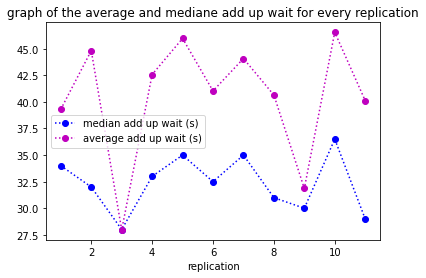

                                   Variance  Standard deviation
Average add up wait / replication     33.58                5.79
Mediane add up wait / replication      7.20                2.68


In [25]:
if NB_REPLI==1 :
    index=["Average for a traveller","Median for a traveller"]
    df=pd.DataFrame(data=[round(np.mean(add_up_wait_list),2),round(statistics.median(add_up_wait_list),2)],index=index,columns=["Wait time (in s)"])
    print(df)
else :
    index1=["average all replications combined","median all replications combined"]
    index2=["Average add up wait / replication","Mediane add up wait / replication"]
    columns=[i+1 for i in range (NB_REPLI)]
    df_1=pd.DataFrame(data=[round(np.mean(add_up_wait_list),2),round(statistics.median(add_up_wait_list),2)],index=index1,columns=["Wait time (in s) for a passenger"])
    print(df_1)
    df_2=pd.DataFrame(data=[np.round(avg_wait_list,2),median_wait_list],index=index2,columns=columns)
    print(pd.DataFrame.transpose(df_2))
    
    # we draw the average and mediane add up wait for every replication
    plt.figure(1)
    plt.plot([i+1 for i in range (NB_REPLI)],median_wait_list,"b:o",label="median add up wait (s)")
    plt.plot([i+1 for i in range (NB_REPLI)],avg_wait_list,"m:o",label="average add up wait (s)")
    plt.legend()
    plt.xlabel("replication")
    plt.title("graph of the average and mediane add up wait for every replication")
    plt.show()
    
    if NB_REPLI>10 : # we calculate the variance, bellow 10 replications it is not very indicative
        data=np.array([[round(statistics.variance(avg_wait_list),2),round(statistics.stdev(avg_wait_list),2)],[round(statistics.variance(median_wait_list),2),round(statistics.stdev(median_wait_list),2)]])
        index=["Average add up wait / replication","Mediane add up wait / replication"]
        columns=["Variance","Standard deviation"] 
        df=pd.DataFrame(data=data,index=index,columns=columns)
        print(df)


the median all replications combined is:  32.5


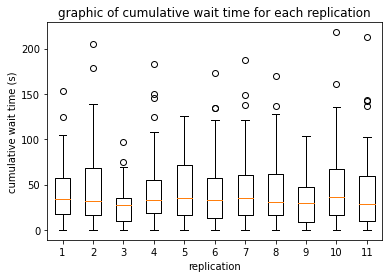

In [26]:
print("the median all replications combined is: ", statistics.median(add_up_wait_list))

plt.boxplot(tot_add_up_wait)
plt.xlabel("replication")
plt.ylabel("cumulative wait time (s)")
plt.title("graphic of cumulative wait time for each replication")
plt.show()

In [27]:
if NB_REPLI<=10: 
    print("On average there are", round(np.mean(tot_nb_st_ride))," stairs ride all replications combined.")
else : # sinon la variance n'est pas très significative
    index=["Number on average","Variance","Standar Deviation"]
    data=[round(np.mean(tot_nb_st_ride)),round(statistics.variance(tot_nb_st_ride),2),round(statistics.stdev(tot_nb_st_ride),2)]
    df=pd.DataFrame(data=data,index=index,columns=["Rides by the stairs / replication"])
    print(df)

                   Rides by the stairs / replication
Number on average                              37.00
Variance                                      140.87
Standar Deviation                              11.87


In [28]:
energy_cost_list = []
avg_energy_list = []
median_energy_list = []

for l in tot_energy_cost:
    energy_cost_list = energy_cost_list + l
    median_energy_list.append(statistics.median(l))
    avg_energy_list.append(np.mean(l))

In [29]:
index=["For an elevator during a day","Overall during a day"]
df_1=pd.DataFrame(data=[round(np.mean(energy_cost_list),2),round(np.mean(energy_cost_list),2) * NB_EVT],index=index,columns=["Average energy cost (kWh)"])
print(df_1)
if NB_REPLI>10 :
    data=[round(statistics.variance(avg_energy_list),2),round(statistics.stdev(avg_energy_list),2)]
    df_2=pd.DataFrame(data=data,index=["Variance","Standard Deviation"],columns=["Average energy cost of an elevator / simul." ])
    print(pd.DataFrame.transpose(df_2))

                              Average energy cost (kWh)
For an elevator during a day                       1.41
Overall during a day                               4.23
                                             Variance  Standard Deviation
Average energy cost of an elevator / simul.      0.28                0.53


In [30]:
df=pd.DataFrame(data=[withdrawal],index=["Number of withdrawal per replication"],columns=[i+1 for i in range(NB_REPLI)])
df.apply(pd.Series)

,1,2,3,4,5,6,7,8,9,10,11
Number of withdrawal per replication,0,0,0,0,0,0,0,0,0,0,0
